# Preface

In this notebook, we will explore the application of PCA for a variety of practical problems, including
   * Feature extraction and dimensionality reduction
   * Denoising
   * Clustering and measuring similarity
   
We will also demonstrate basic usage of `sklearn.decomposition.PCA`, as well as building autoencoders with `keras`. Incidentally, we will also use the `kaggle` API to download some public datasets.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_context('notebook', font_scale=1.25, rc={"lines.linewidth": 2.5})
sns.set_style("darkgrid")
np.random.seed(123)  # For reproducibility

# PCA and Autoecnoders on MNIST

In this section, we perform principal component analysis and autoencoders on the MNIST hand-written digits dataset that we have seen before.

In [3]:
def plot_images(x, nrow=2, ncol=4, randomize=True):
    """
    Plot Images
    """
    fig, ax = plt.subplots(nrow, ncol, figsize=(5*ncol, 4*nrow))
    num_samples = x.shape[0]
    if x.ndim == 2:
        img_size = int(round(np.sqrt(x.shape[-1])))
        assert img_size**2 == x.shape[-1]  # Check Square Image
        x = x.reshape(-1, img_size, img_size)
    for k, a in enumerate(ax.ravel()):
        if randomize:
            j = np.random.choice(num_samples)
        else:
            j = k
        a.imshow(x[j])
        a.set_xticks([])
        a.set_yticks([])

We import the data using `keras`. You can also directly download it from the [web](http://yann.lecun.com/exdb/mnist/).

In [4]:
from tensorflow.keras.datasets.mnist import load_data

In [5]:
(images_train, _), (images_test, _) = load_data()
images_train = images_train / 255.0
images_test = images_test / 255.0

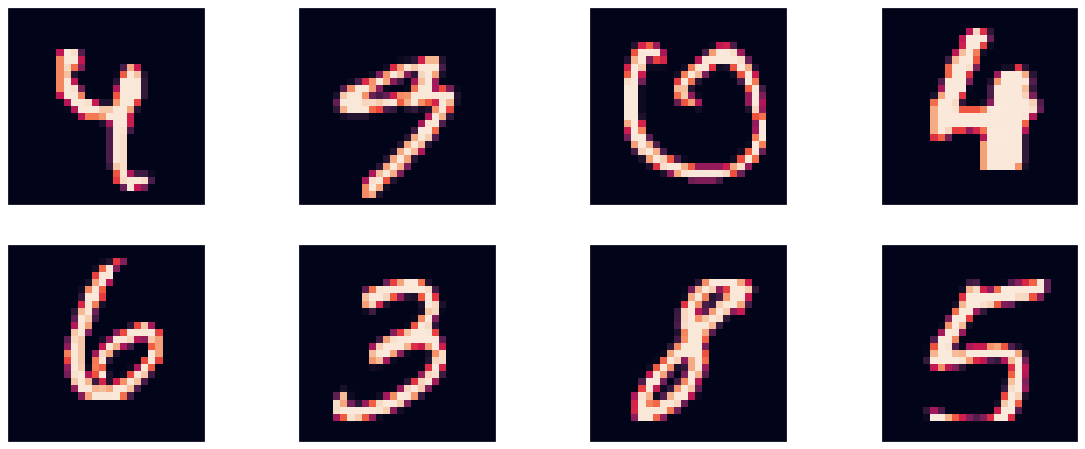

In [6]:
plot_images(images_train)

## PCA

Let us now perform PCA. For demonstration we will only work with the training set and evaluate our performance on the test set. In general, depending on the task at hand this splitting may be unnecesssary. For example, if we are interested in compression or feature extraction then there is no need for a train-test split.

Here, we will use the `sklearn.decomposition.PCA` class to perform PCA.

In [9]:
from sklearn.decomposition import PCA

In [61]:
pca = PCA(n_components=64)
pca.fit(images_train.reshape(-1, 784))

PCA(copy=True, iterated_power='auto', n_components=64, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

### Eigenvalues / Explained Variance

Now, we plot the eigenvalues of the sample covariance matrix (equivalently, the singular values of the data matrix). Note that they are arranged in decreasing order and accessible from the `explained_variance_` attribute.

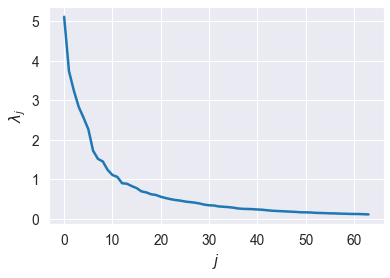

In [62]:
plt.plot(pca.explained_variance_)
plt.xlabel(r'$j$')
plt.ylabel(r'$\lambda_j$');

We can also see what principal component axes are identified. These are accessible through the `components_` attribute. 

**Remark.**
Unlike our notation in the notes, here each eigenvector is a *row*, instead of a *column* of the matrix `pca.components_`. In other words, `pca.components_(j)` is the $j^\text{th}$ eigenvector. 

### Principal Component Axes

In [63]:
pca.components_.shape

(64, 784)

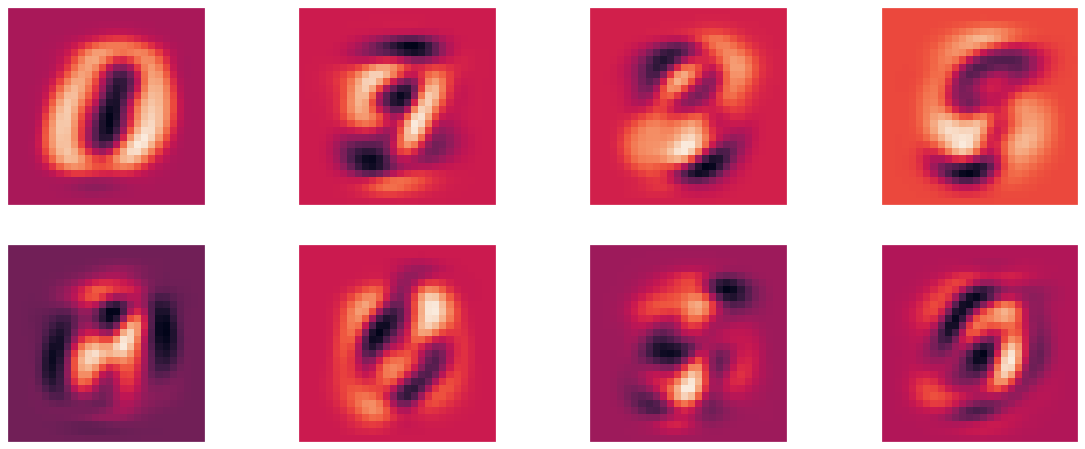

In [64]:
plot_images(pca.components_, randomize=False)

### Reconstruction using Principal Component Scores

We demonstrate how to get back our image. As discussed, the PCA compression gives the rescaled latents
$$
    Z_m = X U_m \Lambda^{-1/2}
$$
Here, the latents are computed by calling `pca.transform`.

The inverse transform is given by
$$
    X'_m = Z_m U_m^T \Lambda^{1/2}
$$
This gives us the reconstructed image. Here, it is computed using `pca.inverse_transform`.

In [65]:
scores = pca.transform(images_test.reshape(-1, 784))
images_recon = pca.inverse_transform(scores)

Let us see how well we did!

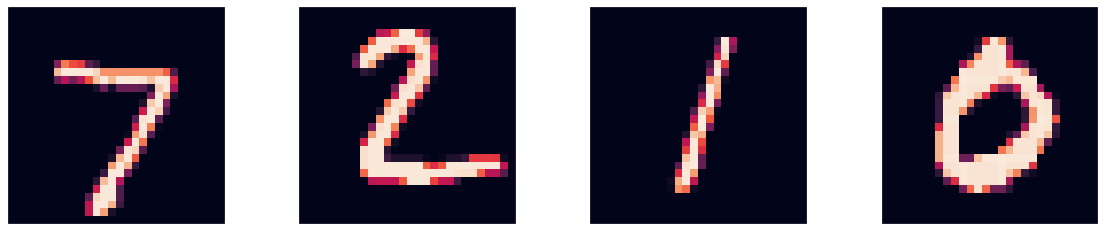

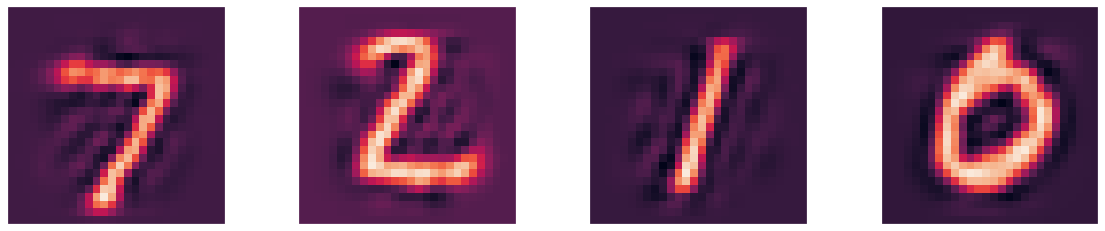

In [66]:
plot_images(images_test, randomize=False, nrow=1)
plot_images(images_recon, randomize=False, nrow=1)

## Autoencoder with Neural Networks

Let us now try to do the same compression, but with a nonlinear neural network as encoder and decoder functions.

In [67]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense

In [68]:
def encoder(x):
    x = Dense(units=128, activation='relu')(x)
    x = Dense(units=64, activation='relu')(x)
    return x

def decoder(x):
    x = Dense(units=128, activation='relu')(x)
    x = Dense(units=784, activation='sigmoid')(x)
    return x

In [69]:
x = Input(shape=(784,))
z = encoder(x)
x_recon = decoder(z)

autoencoder = Model(inputs=x, outputs=x_recon)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [70]:
autoencoder.fit(
    x=images_train.reshape(-1, 784),
    y=images_train.reshape(-1, 784),
    batch_size=128,
    epochs=10,
)

Epoch 1/10
469/469 [==============================] - 2s 4ms/step - loss: 0.1785
Epoch 2/10
469/469 [==============================] - 1s 3ms/step - loss: 0.1060
Epoch 3/10
469/469 [==============================] - 1s 3ms/step - loss: 0.0954
Epoch 4/10
469/469 [==============================] - 1s 3ms/step - loss: 0.0899
Epoch 5/10
469/469 [==============================] - 2s 3ms/step - loss: 0.0866
Epoch 6/10
469/469 [==============================] - 2s 4ms/step - loss: 0.0843
Epoch 7/10
469/469 [==============================] - 2s 3ms/step - loss: 0.0826
Epoch 8/10
469/469 [==============================] - 2s 3ms/step - loss: 0.0811
Epoch 9/10
469/469 [==============================] - 2s 3ms/step - loss: 0.0800
Epoch 10/10
469/469 [==============================] - 2s 3ms/step - loss: 0.0790


In [71]:
images_recon_ae = autoencoder.predict(x=images_test.reshape(-1, 784))

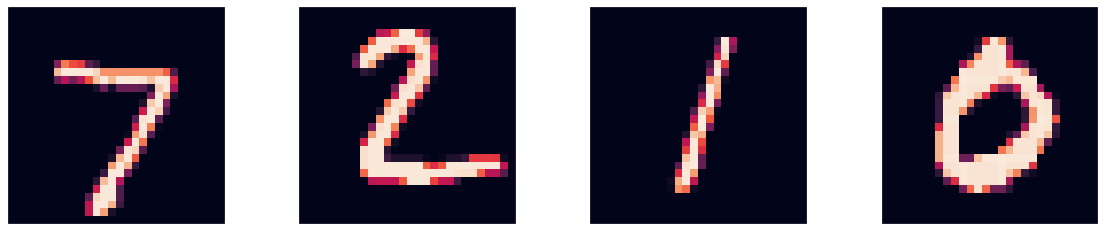

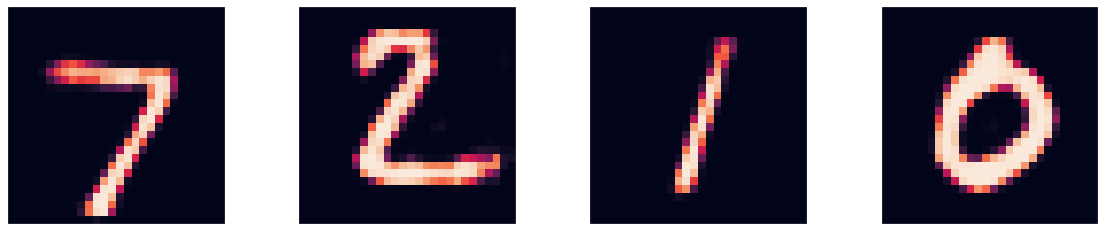

In [72]:
plot_images(images_test, randomize=False, nrow=1)
plot_images(images_recon_ae, randomize=False, nrow=1)

## Denoising using PCA and AE

Now, let us see another use for PCA and Autoencoders: denoising.

In [73]:
def add_noise_and_clip(x):
    """
    Add Gaussian noise to images
    """
    x = x + 0.2 * np.random.normal(size=x.shape)
    x = np.maximum(x, 0.0)
    x = np.minimum(x, 1.0)
    return x

We first create some noisy images.

In [76]:
images_train_noisy = add_noise_and_clip(images_train)
images_test_noisy = add_noise_and_clip(images_test)

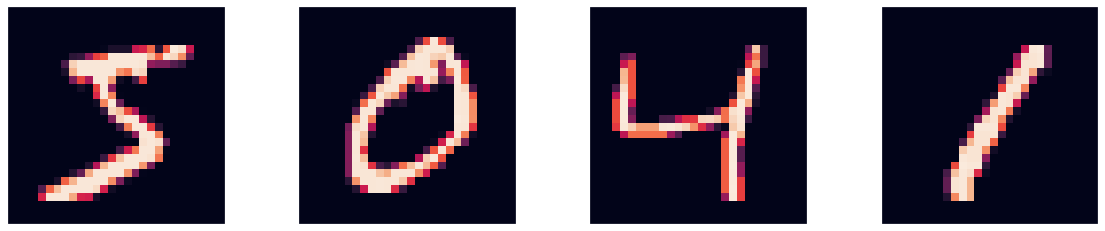

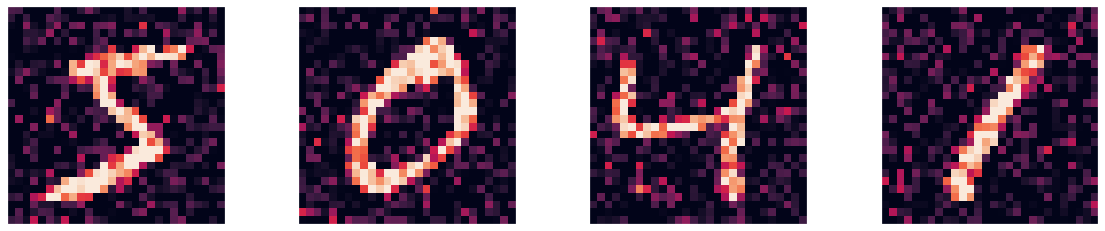

In [77]:
plot_images(images_train, randomize=False, nrow=1)
plot_images(images_train_noisy, randomize=False, nrow=1)

### PCA

Using the PCA, we can transform the noisy image into the latent space and then back. Because this encoding-decoding scheme is lossy, it actually drops many unimportant features in the data, including the noise!

In [78]:
scores = pca.transform(images_test_noisy.reshape(-1, 784))
images_recon = pca.inverse_transform(scores)

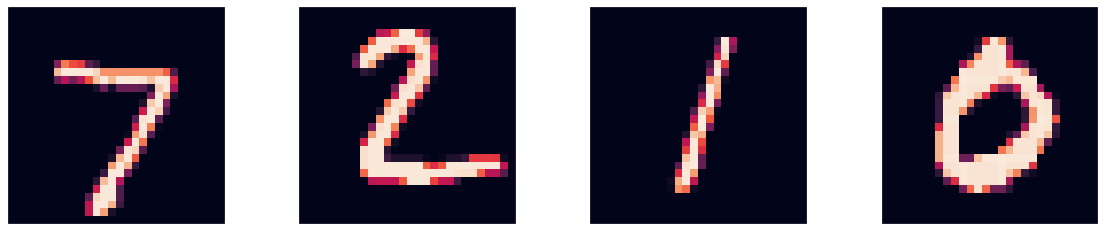

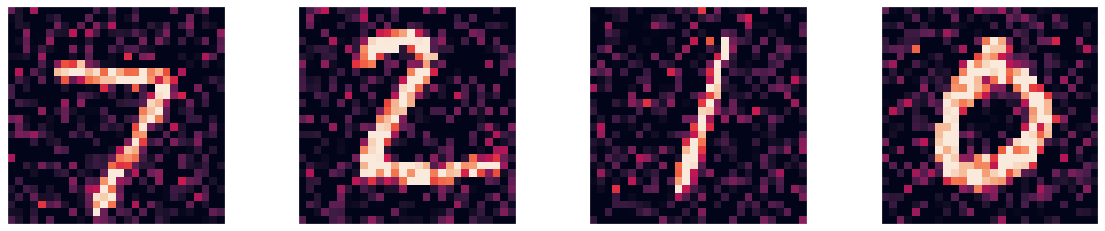

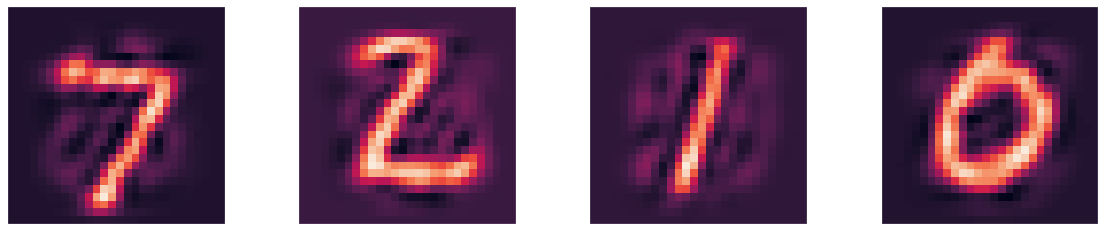

In [79]:
plot_images(images_test, randomize=False, nrow=1)
plot_images(images_test_noisy, randomize=False, nrow=1)
plot_images(images_recon, randomize=False, nrow=1)

### AutoEncoder

We can do the same with autoencoders.

In [80]:
images_recon_ae = autoencoder.predict(x=images_test_noisy.reshape(-1, 784))

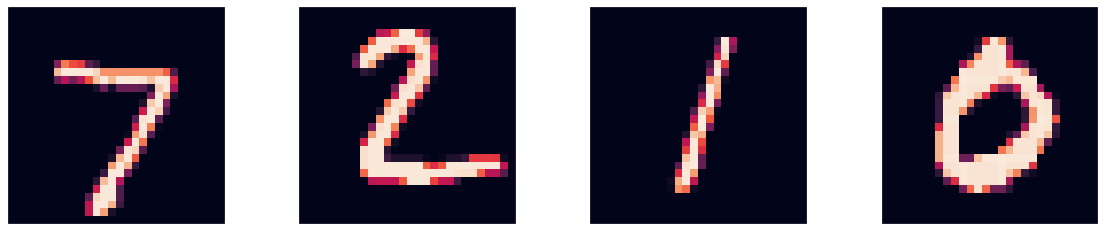

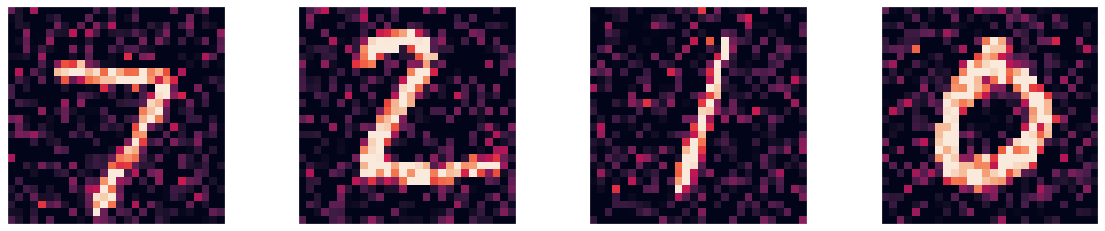

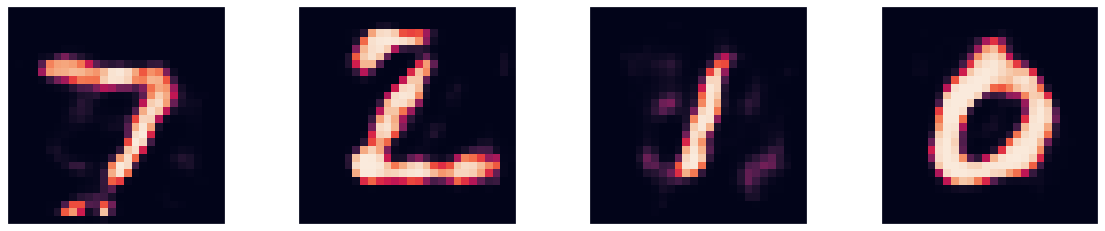

In [81]:
plot_images(images_test, randomize=False, nrow=1)
plot_images(images_test_noisy, randomize=False, nrow=1)
plot_images(images_recon_ae, randomize=False, nrow=1)

**Remark.**
To obtain better performance, you may want to train the autoencoder with noisy inputs and clean outputs in the data. This is called *denoising autoencoders* and are very useful to remove noise, provided that you have noisy samples from the same distribution.

# PCA and Data Normalization

We are going to demonstrate the importance of data normalization in PCA using a real-world dataset. 

This is a dataset from `kaggle` which contains [sales from supermarkets](https://www.kaggle.com/aungpyaeap/supermarket-sales) in three cities in Myanmar. We will import it using the `kaggle` API. Follow the instructions [here](https://github.com/Kaggle/kaggle-api) to set this up. This allows easy downloading of datasets from [https://www.kaggle.com/datasets](https://www.kaggle.com/datasets). Of course, you can also directly download all the data from the website.

In [82]:
import kaggle
kaggle.api.authenticate()

kaggle.api.dataset_download_files(
    'aungpyaeap/supermarket-sales',
    path='./data',
    quiet=False,
    unzip=True
)

100%|██████████| 35.9k/35.9k [00:00<00:00, 7.72MB/s]

In [83]:
supermarket_data = pd.read_csv('./data/supermarket_sales - Sheet1.csv')

## Visualization

In [85]:
supermarket_data.head()

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,13:08,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,13:23,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,20:33,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37,Ewallet,604.17,4.761905,30.2085,5.3


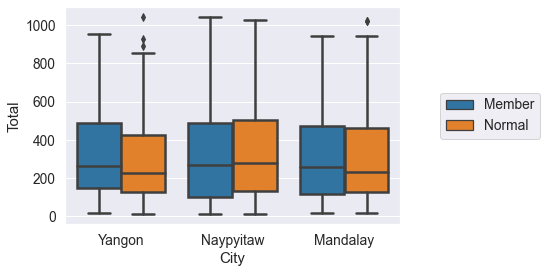

In [86]:
ax = sns.boxplot(x='City', y='Total', data=supermarket_data, hue='Customer type')
ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.5), ncol=1)

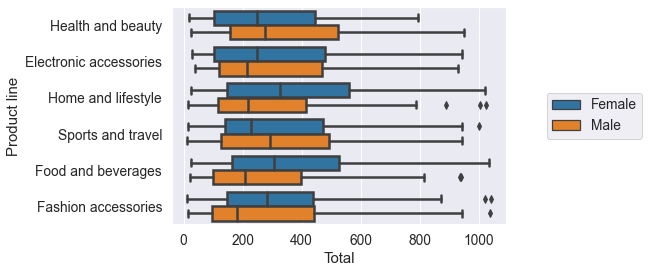

In [87]:
ax = sns.boxplot(x='Total', y='Product line', data=supermarket_data, hue='Gender')
ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.5), ncol=1);

## PCA

Let us Perform PCA on the supermarket dataset to uncover some hidden relationships. We first remove some attributes for simplicity.

In [88]:
for c in ['Invoice ID', 'Branch', 'Tax 5%', 'Date', 'Time', 'gross margin percentage']:
    supermarket_data.pop(c)

supermarket_data = pd.get_dummies(supermarket_data)

In [89]:
supermarket_data

,Unit price,Quantity,Total,cogs,gross income,Rating,City_Mandalay,City_Naypyitaw,City_Yangon,Customer type_Member,...,Gender_Male,Product line_Electronic accessories,Product line_Fashion accessories,Product line_Food and beverages,Product line_Health and beauty,Product line_Home and lifestyle,Product line_Sports and travel,Payment_Cash,Payment_Credit card,Payment_Ewallet
0,74.69,7,548.9715,522.83,26.1415,9.1,0,0,1,1,...,0,0,0,0,1,0,0,0,0,1
1,15.28,5,80.2200,76.40,3.8200,9.6,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
2,46.33,7,340.5255,324.31,16.2155,7.4,0,0,1,0,...,1,0,0,0,0,1,0,0,1,0
3,58.22,8,489.0480,465.76,23.2880,8.4,0,0,1,1,...,1,0,0,0,1,0,0,0,0,1
4,86.31,7,634.3785,604.17,30.2085,5.3,0,0,1,0,...,1,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,40.35,1,42.3675,40.35,2.0175,6.2,0,1,0,0,...,1,0,0,0,1,0,0,0,0,1
996,97.38,10,1022.4900,973.80,48.6900,4.4,1,0,0,0,...,0,0,0,0,0,1,0,0,0,1
997,31.84,1,33.4320,31.84,1.5920,7.7,0,0,1,1,...,1,0,0,1,0,0,0,1,0,0
998,65.82,1,69.1110,65.82,3.2910,4.1,0,0,1,0,...,1,0,0,0,0,1,0,1,0,0


Now, we perform PCA.

In [90]:
pca = PCA()
pca.fit(supermarket_data)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

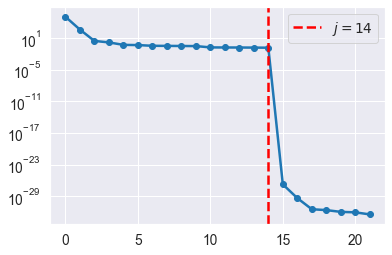

In [94]:
plt.semilogy(pca.explained_variance_, '-o')
plt.axvline(x=14, c='r', ls='--', label=r'$j=14$')
plt.legend()

The eigenvalues (explained variance) drops drastically after the 14<sup>th</sup> component. Moreover, the first component *drastically* Dominates the rest. In fact, we can plot a normalized view below:

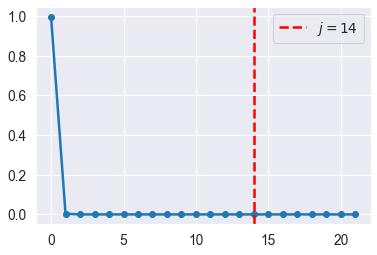

In [95]:
plt.plot(pca.explained_variance_ratio_, '-o')
plt.axvline(x=14, c='r', ls='--', label=r'$j=14$')
plt.legend()

## Principal Components

Let us look at what principal components we obtained.

Text(0.5, 1.0, 'Second Principal Component Axis')

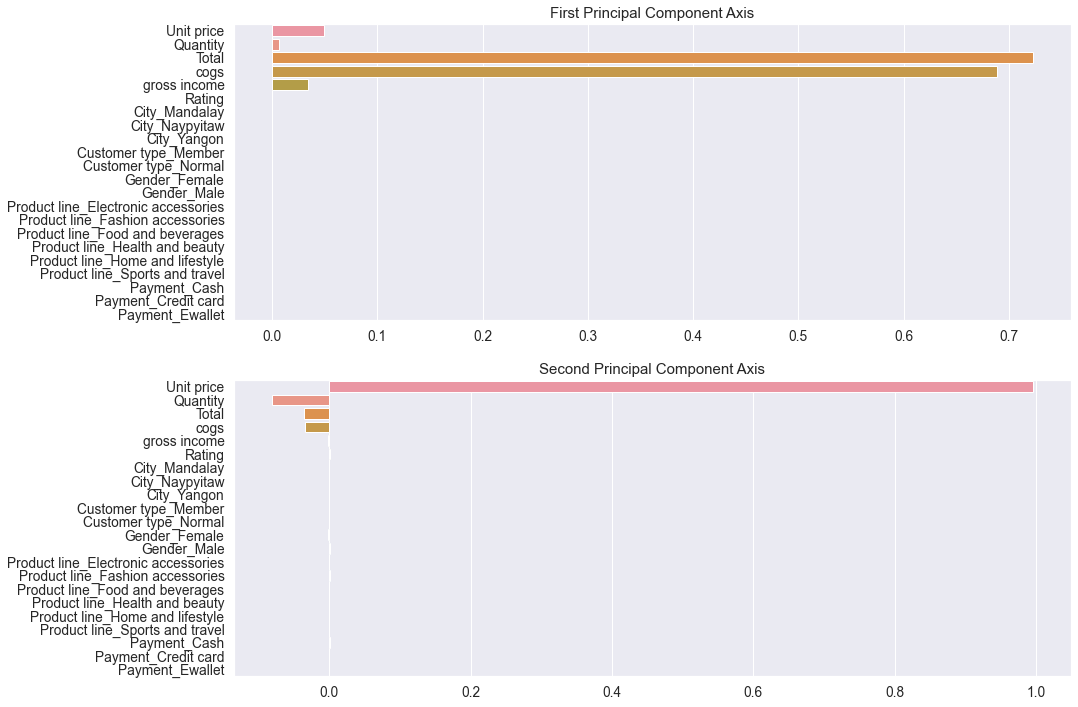

In [96]:
fig, ax = plt.subplots(2, 1, figsize=(15, 12))
sns.barplot(x=pca.components_[0], y=supermarket_data.columns, orient='h', ax=ax[0])
sns.barplot(x=pca.components_[1], y=supermarket_data.columns, orient='h', ax=ax[1])

ax[0].set_title('First Principal Component Axis')
ax[1].set_title('Second Principal Component Axis')

What's wrong? It appears that everything is dominated by either the total price, or the unit price!

This make sense, since these numbers are on the order of 10s or 100s, whereas the other features have much smaller values. Then, of course the majority of the variance is going to be dominated by these features. This is undesirable. 

To resolve this, let us use `sklearn.preprocessing` module to normalize the data.

In [97]:
from sklearn.preprocessing import minmax_scale
supermarket_data_normalized = (supermarket_data - supermarket_data.min()) / (
    supermarket_data.max() - supermarket_data.min())

Then, we recheck our PCA results.

In [98]:
pca.fit(supermarket_data_normalized)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

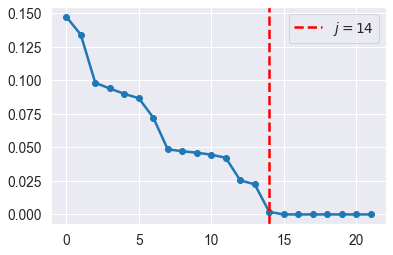

In [99]:
plt.plot(pca.explained_variance_ratio_, '-o')
plt.axvline(x=14, c='r', ls='--', label=r'$j=14$')
plt.legend()

Text(0.5, 1.0, 'Third Principal Component Axis')

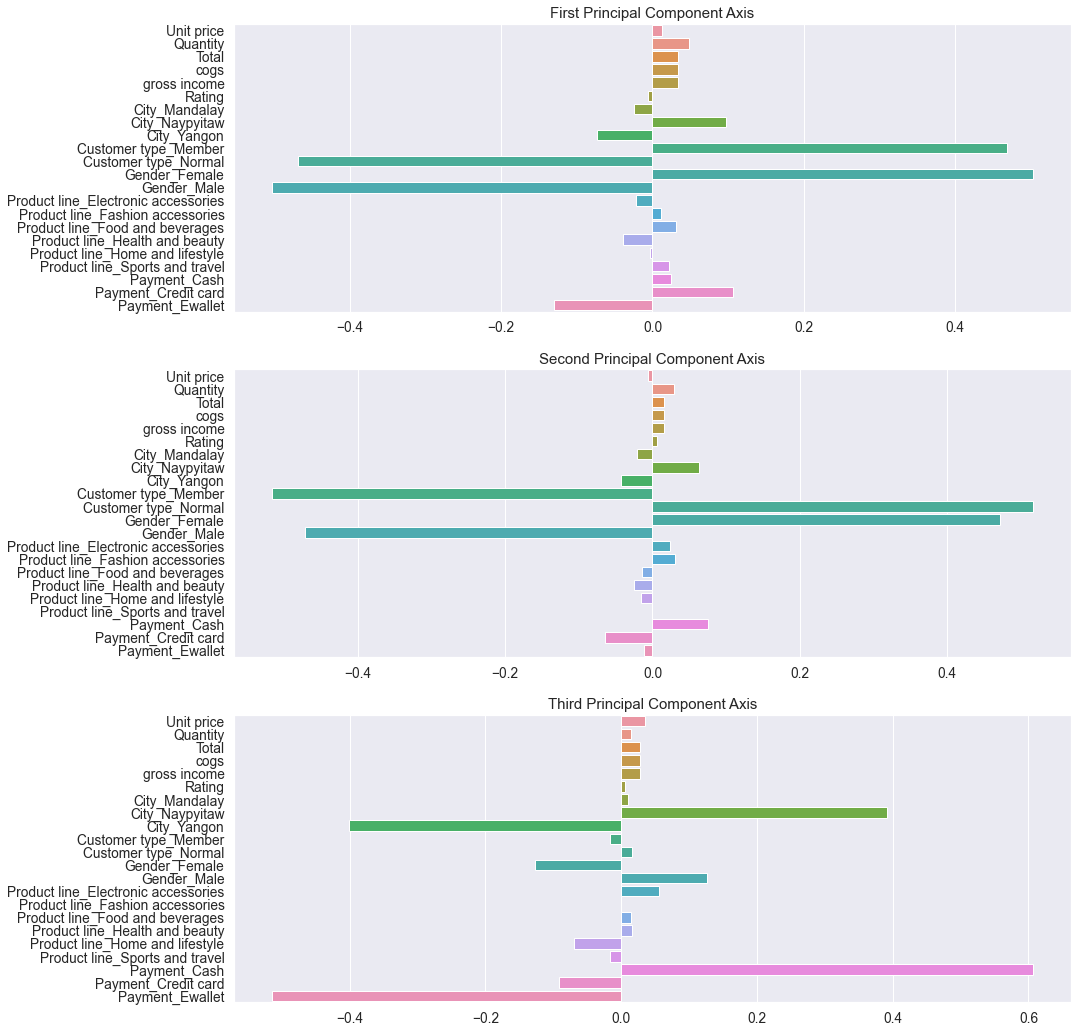

In [100]:
fig, ax = plt.subplots(3, 1, figsize=(15, 18))
sns.barplot(x=pca.components_[0], y=supermarket_data.columns, orient='h', ax=ax[0])
sns.barplot(x=pca.components_[1], y=supermarket_data.columns, orient='h', ax=ax[1])
sns.barplot(x=pca.components_[2], y=supermarket_data.columns, orient='h', ax=ax[2])

ax[0].set_title('First Principal Component Axis')
ax[1].set_title('Second Principal Component Axis')
ax[2].set_title('Third Principal Component Axis')

# PCA-based Recommender System

Now, let us demonstrate another usage of PCA. Instead of compression and reconstruction, we are going to use PCA to extract principal features, from which we can build simple recommendation systems.

For our dataset, we are going to use the [product SKUs](https://www.kaggle.com/cclark/product-item-data) from an apparel store hosted on kaggle.

In [101]:
import kaggle
kaggle.api.authenticate()

kaggle.api.dataset_download_files(
    'cclark/product-item-data',
    path='./data',
    quiet=False,
    unzip=True
)

100%|██████████| 137k/137k [00:00<00:00, 7.23MB/s]

In [102]:
SKU_data = pd.read_csv('./data/sample-data.csv')

In [103]:
SKU_data

,id,description
0,1,Active classic boxers - There's a reason why o...
1,2,Active sport boxer briefs - Skinning up Glory ...
2,3,Active sport briefs - These superbreathable no...
3,4,"Alpine guide pants - Skin in, climb ice, switc..."
4,5,"Alpine wind jkt - On high ridges, steep ice an..."
...,...,...
495,496,Cap 2 bottoms - Cut loose from the maddening c...
496,497,Cap 2 crew - This crew takes the edge off fick...
497,498,All-time shell - No need to use that morning T...
498,499,All-wear cargo shorts - All-Wear Cargo Shorts ...


Now, we are going to featurize the description. We will use the handy `TfidVectorizer` from `sklearn.feature_extraction.text`. This implements a bag-of-words embedding, meaning that we count the frequency of English words (and also symbols) at each sentence and have an abstract embedding of the counts. The actual implementation is slightly more complicated. You can read more about that [here](https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction).

In [104]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [110]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(SKU_data['description'])
X = tfidf_matrix.todense()

Sample representation of 
Active classic boxers - There's a reason why our boxers are a cult favorite - they keep their cool, especially in sticky situations. The quick-drying, lightweight underwear takes up minimal space in a travel pack. An exposed, brushed waistband offers next-to-skin softness, five-panel construction with a traditional boxer back for a classic fit, and a functional fly. Made of 3.7-oz 100% recycled polyester with moisture-wicking performance. Inseam (size M) is 4 1/2". Recyclable through the Common Threads Recycling Program.<br><br><b>Details:</b><ul> <li>"Silky Capilene 1 fabric is ultralight, breathable and quick-to-dry"</li> <li>"Exposed, brushed elastic waistband for comfort"</li> <li>5-panel construction with traditional boxer back</li> <li>"Inseam (size M) is 4 1/2"""</li></ul><br><br><b>Fabric: </b>3.7-oz 100% all-recycled polyester with Gladiodor natural odor control for the garment. Recyclable through the Common Threads Recycling Program<br><br><b>Weight:

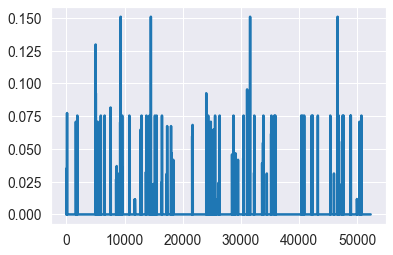

In [106]:
print(f'Sample representation of \n{SKU_data.iloc[0,1]}')
plt.plot(np.asarray(X)[0])

Let us now perform PCA on the extracted text features.

In [112]:
from sklearn.decomposition import PCA

In [113]:
pca = PCA(n_components=100)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=100, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

Visualize explained variance.

Text(0, 0.5, '$\\lambda_j$')

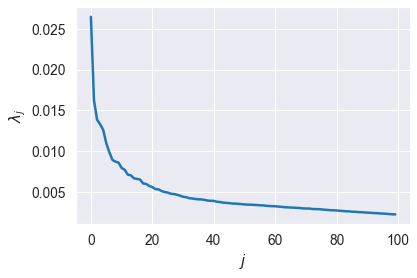

In [114]:
plt.plot(pca.explained_variance_)
plt.xlabel(r'$j$')
plt.ylabel(r'$\lambda_j$')

Let us now transform to latent space. This is a space of important features.

In [115]:
latents = pca.transform(X)

We can visualize the distribution of the data in the first three latent dimensions in different combinations

In [116]:
latents = pd.DataFrame(
    data=latents,
    columns=[f'Latent dim {i+1}' for i in range(latents.shape[-1])],
)

In [117]:
latents.shape

(500, 100)

<AxesSubplot:xlabel='Latent dim 1', ylabel='Latent dim 2'>

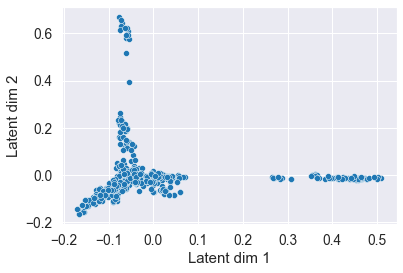

In [118]:
sns.scatterplot(
    x='Latent dim 1',
    y='Latent dim 2',
    data=latents,
)

<AxesSubplot:xlabel='Latent dim 1', ylabel='Latent dim 3'>

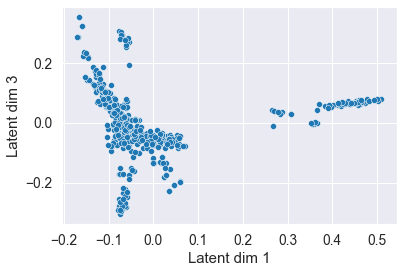

In [119]:
sns.scatterplot(
    x='Latent dim 1',
    y='Latent dim 3',
    data=latents,
)

<AxesSubplot:xlabel='Latent dim 2', ylabel='Latent dim 3'>

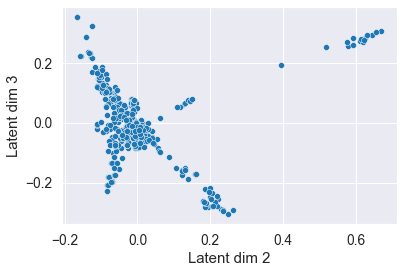

In [120]:
sns.scatterplot(
    x='Latent dim 2',
    y='Latent dim 3',
    data=latents,
)

Observe that we can already see some clustering behaviour, as should be expected since the merchandize descriptions overlap for similar items!

## Simple Recommender System

Based on the above observations, similar items should have similar principal component scores. So, let us simply take the *distance* in the latent space as a measure of similarity. 

This allows us to find, given an input sample item description, similar items to it. Consequently, we can make a recommender system from this! 

For any given input which represent an item a customer purchased, we will recommend some closest neighbour to this in the PCA latent space. Hopefully this gives similar items that the customer might want to look at. Interestingly, we can do this just from the SKU catalogue!

In [122]:
def recommend(bought_id, num_recommendation=5):
    """
    A simple recommender system using PCA
    """
    print(f'You bought:\n\n{SKU_data.description[bought_id][:100]}'+'...')
    
    # Compute PC scores using only first 10 components
    scores = latents.to_numpy()[:, :10]
    
    # Compute L^2 distances to the input Score
    distances = np.sum((scores - scores[bought_id, np.newaxis, :])**2, axis=1)
    
    # Return recommendations based on closest products in PCA latent space
    rec_ids = np.argsort(distances)[1:1+num_recommendation]
    rec_desc = SKU_data.description[rec_ids].to_numpy()
    print('\n\nWe recommend:\n')
    for i, d in zip(rec_ids, rec_desc):
        print(f'Id: {i} | Product: {d[:80]+"..."}')

In [125]:
recommend(37)

You bought:

Elias fz sweatshirt - Clean as a Wingate splitter. Our Elias is made from a welcoming blend of 95% o...


We recommend:

Id: 278 | Product: Cotton fleece hoody - When Central Coast nights turn on the chill factor, layer ...
Id: 181 | Product: Elsa tunic - The Elsa Tunic flourishes in heat-prone latitudes where its cool na...
Id: 284 | Product: Ester top - Throw on the Ester Top for a quick surf check - its low-maintenance ...
Id: 125 | Product: S/s pragmatist shirt - Like a spare roll of duct tape, the Pragmatist shirt work...
Id: 282 | Product: Drift shirt - All epic tales of the West begin with a drifter - many were women ...
